# Setup

In [1]:
%cd  /home/tlm/Work/FYP-22-23/weee-preprocess

/home/tlm/Work/FYP-22-23/weee-preprocess


In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
DATASET_DIR = "./data/v1"
SAMPLING_RATE = 100 # Hz

# Prepare Data

In [4]:
from utils.dataset import StudyInfoEncoder, DatasetVersion1
from utils.naming import standardize_column_names
from utils.time import parse_simple_timedelta

In [5]:
dataset = DatasetVersion1()
activity_encoder = StudyInfoEncoder(os.path.join(DATASET_DIR, "Study_Information.csv"))

In [18]:
def process_task(p):
    left, right = dataset.earbud_acc(participant=p)
    
    # pre touch ups
    ideal_timestamp = pd.date_range(right['timestamp'].iloc[0], right['timestamp'].iloc[-1], freq=f"1s", tz='UTC')
    ideal_timestamp = ideal_timestamp.tz_convert(None) # remove timezone info from timestamp
    df = pd.concat([
        right, 
        pd.DataFrame({ 'timestamp': ideal_timestamp, 'ax': np.nan, 'ay': np.nan, 'az': np.nan })
    ], axis=0).sort_values('timestamp')
    
    # process
    df = df.rolling('60s', center=True, on="timestamp", min_periods=1).mean()
    # set first and last 30 seconds to ax, ay, az to nan
    col_indices = [ df.columns.get_loc(c) for c in ['ax', 'ay', 'az'] ]
    for c in col_indices:
        df.iloc[df['timestamp'] < df['timestamp'].iloc[0] + parse_simple_timedelta("30s"), c] = np.nan
        df.iloc[df['timestamp'] > df['timestamp'].iloc[-1] - parse_simple_timedelta("30s"), c] = np.nan
    
    # post touch ups
    df.insert(1, 'user_id', p)
    df = activity_encoder.fit_activity_column(
        df, p,
        timestamp_column='timestamp',
        activity_column='session_type',
        activity_column_index=2
    )
    df = standardize_column_names(df)
    print(f"Done processing participant {p:02d}")
    
    return df

In [31]:
e4_acc_p1 = process_task(1)

# drop 30 seconds from start and end
e4_acc_p1 = e4_acc_p1[e4_acc_p1['timestamp'] > e4_acc_p1['timestamp'].iloc[0] + parse_simple_timedelta("30s")]
e4_acc_p1 = e4_acc_p1[e4_acc_p1['timestamp'] < e4_acc_p1['timestamp'].iloc[-1] - parse_simple_timedelta("30s")]

Done processing participant 01


<AxesSubplot: xlabel='timestamp', ylabel='ax'>

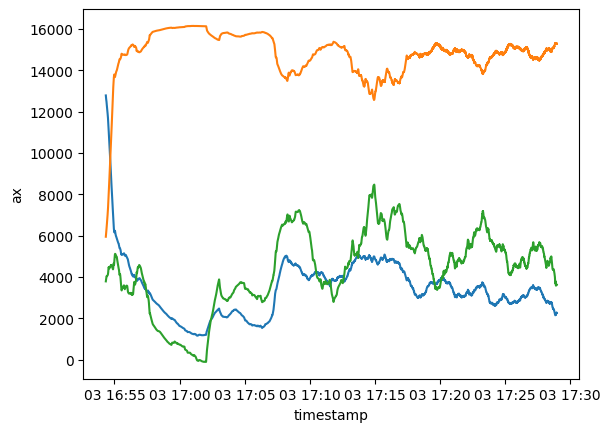

In [32]:
# all ax, ay, az plots in same figure; use estimator=None, n_boot=0
sns.lineplot(data=e4_acc_p1, x='timestamp', y='ax', estimator=None, n_boot=0)
sns.lineplot(data=e4_acc_p1, x='timestamp', y='ay', estimator=None, n_boot=0)
sns.lineplot(data=e4_acc_p1, x='timestamp', y='az', estimator=None, n_boot=0)

In [ ]:
e4_acc = pd.concat([process_task(p) for p in range(1, 18)], axis=0, ignore_index=True).reset_index()

Done processing participant 01
Done processing participant 02
Done processing participant 03
Done processing participant 04
Done processing participant 05
Done processing participant 06
Done processing participant 07
Done processing participant 08
Done processing participant 09
Done processing participant 10
Done processing participant 11
Done processing participant 12
Done processing participant 13
Done processing participant 14
Done processing participant 15
Done processing participant 16
Done processing participant 17


# Windowing

In [ ]:
WINDOW_SIZES = ['2s', '4s', '6s', '8s', '10s', '12s']
AGG_FUNCS = ['mean', 'std', 'min', 'max', 'median']
SKIP_FROM_START_SIT = '30s'

In [ ]:
def create_non_overlapping_windows(data, window_size, agg_funcs, ignore_incomplete_windows=True):
    dfs = []
    for p, p_df in data.groupby('user_id'):
        
        if SKIP_FROM_START_SIT:
            skip = parse_simple_timedelta(SKIP_FROM_START_SIT)
            p_df = activity_encoder.crop_from_start_time(p_df, p, offset=skip)
        
        for a, pa_df in p_df.groupby('session_type'):
            # pre touch ups
            df = pa_df.sort_values('timestamp')

            # create windows and aggregate
            agg_cols = {c: agg_funcs for c in df.columns if c not in ['timestamp', 'session_type', 'user_id']}
            agg_cols['timestamp'] =  ['first', 'last']
            windowed = df.groupby(pd.Grouper(key='timestamp', freq=window_size, origin='start')).agg(agg_cols)

            # post touch ups
            windowed.columns = ['_'.join(col).strip() for col in windowed.columns.values]
            windowed = windowed.reset_index()
            windowed.insert(0, 'user_id', p)
            windowed.insert(1, 'session_type', a)
            windowed.insert(2, 'window_number', range(len(windowed)))
            windowed.insert(3, 'start_timestamp', windowed.pop('timestamp_first').dt.floor(freq='s'))
            windowed.insert(4, 'end_timestamp', windowed.pop('timestamp_last').dt.ceil(freq='s'))
            windowed.drop(columns=['timestamp'], inplace=True)
            if (windowed.iloc[-1]['end_timestamp'] - windowed.iloc[-1]['start_timestamp']) < parse_simple_timedelta(window_size):
                # remove last window if it is incomplete
                windowed.drop(windowed.tail(1).index, inplace=True)
                
            dfs.append(windowed)
            
    return pd.concat(dfs, axis=0, ignore_index=True)

In [ ]:
%mkdir -p data/v2/EARBUDS
DATASET_DIR_V2 = "data/v2"

In [ ]:
for ws in WINDOW_SIZES:
    earbuds_acc_windowed = create_non_overlapping_windows(e4_acc, ws, AGG_FUNCS)
    earbuds_acc_windowed.to_csv(os.path.join(DATASET_DIR_V2, 'EARBUDS', f"earbuds_acc_{ws}.csv"), index=False)
    print(f"Done processing window size {ws}")

Done processing window size 2s
Done processing window size 4s
Done processing window size 6s
Done processing window size 8s
Done processing window size 10s
Done processing window size 12s


In [ ]:
earbuds_acc_windowed

,user_id,session_type,window_number,start_timestamp,end_timestamp,level_0_mean,level_0_std,level_0_min,level_0_max,level_0_median,...,az_mean,az_std,az_min,az_max,az_median,index_mean,index_std,index_min,index_max,index_median
0,1,0,0,2021-12-03 16:59:20,2021-12-03 16:59:32,34398.5,364.452329,33768.0,35029.0,34398.5,...,782.416732,43.374696,710.68816,821.49232,812.70104,33740.811471,357.611163,33121.704437,34359.923138,33740.813788
1,1,0,1,2021-12-03 16:59:32,2021-12-03 16:59:44,35660.5,364.452329,35030.0,36291.0,35660.5,...,838.188588,21.986602,810.26912,875.33952,835.83944,34979.039680,357.611163,34359.932647,35598.151347,34979.041997
2,1,0,2,2021-12-03 16:59:44,2021-12-03 16:59:56,36922.5,364.452329,36292.0,37553.0,36922.5,...,776.455425,15.509448,748.78832,813.49776,775.04752,36217.267889,357.611163,35598.160856,36836.379556,36217.270206
3,1,0,3,2021-12-03 16:59:56,2021-12-03 17:00:08,38184.5,364.452329,37554.0,38815.0,38184.5,...,718.097286,15.092691,683.46288,748.78832,718.23464,37455.496098,357.611163,36836.389065,38074.607765,37455.498415
4,1,0,4,2021-12-03 17:00:08,2021-12-03 17:00:20,39446.5,364.452329,38816.0,40077.0,39446.5,...,647.891472,14.844812,629.84480,683.46288,640.27440,38693.724308,357.611163,38074.617274,39312.835975,38693.726624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,17,5,13,2021-12-02 17:36:16,2021-12-02 17:36:28,4518371.5,364.452329,4517741.0,4519002.0,4518371.5,...,-5214.833227,48.019504,-5271.20976,-5119.97200,-5238.11464,222366.609447,357.605178,221747.545959,222984.783677,222366.164818
3077,17,5,14,2021-12-02 17:36:28,2021-12-02 17:36:40,4519633.5,364.452329,4519003.0,4520264.0,4519633.5,...,-5280.761357,34.460719,-5358.18016,-5206.80048,-5280.48952,223604.837656,357.605178,222985.774168,224223.011886,223604.393027
3078,17,5,15,2021-12-02 17:36:40,2021-12-02 17:36:52,4520895.5,364.452329,4520265.0,4521526.0,4520895.5,...,-5337.911824,27.902127,-5383.97328,-5275.98400,-5349.24432,224843.065865,357.605178,224224.002377,225461.240095,224842.621236
3079,17,5,16,2021-12-02 17:36:52,2021-12-02 17:37:04,4522157.5,364.452329,4521527.0,4522788.0,4522157.5,...,-5231.555469,70.609634,-5353.21216,-5053.96176,-5246.65312,226081.294075,357.605178,225462.230586,226699.468304,226080.849445
